# Dataaugmentation

## Version 1.0

Has a Torchvision and a Albumentations part

The Torchvision part wasnt working, therefore the albumentations part was added


## Imports

In [1]:
import pathlib
import os
import torch
import torch.utils.data
import torchvision

from PIL import Image
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# Torchvision

(Doesnt Work in the model!!)

Source: https://pytorch.org/vision/stable/transforms.html

In [2]:
os.path.exists("../../../old/BAA/Data/train/")

PATH_IMAGES = "../../../old/BAA/Data/train/"
PATH_ANNOTATIONS = "../../../old/BAA/Data/train/coco_train.json"
TEST_FILE = "../Test/"

transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)


In [3]:
dataset = datasets.CocoDetection(PATH_IMAGES, PATH_ANNOTATIONS, transforms=transforms)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys="all")

In [5]:
#dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys="all")

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")
print(sample)

TypeError: Cannot create a consistent method resolution
order (MRO) for bases VisionDatasetTVTensorWrapper, WrappedCocoDetection

In [6]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, image_name, transforms=None):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file, transforms)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        
		
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [7]:
dataset = datasets.CocoDetection(PATH_IMAGES, PATH_ANNOTATIONS)

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{type(target[0]) = }\n{target[0].keys() = }")
print(sample)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
type(img) = <class 'PIL.Image.Image'>
type(target) = <class 'list'>
type(target[0]) = <class 'dict'>
target[0].keys() = dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'bbox', 'ignore', 'iscrowd', 'area'])
(<PIL.Image.Image image mode=RGB size=1944x1200 at 0x1A6023EC610>, [{'id': 122, 'image_id': 20459, 'category_id': 4, 'segmentation': [[356.7479345947289, 386.81574443703914, 355.56164755033035, 377.32544808185065, 331.8359066623592, 369.61458229325996, 334.2084807511563, 382.0705962594449]], 'bbox': [331.8359066623592, 369.61458229325996, 24.91202793236971, 17.201162143779186], 'ignore': 0, 'iscrowd': 0, 'area': 242.75527416961268}, {'id': 123, 'image_id': 20459, 'category_id': 9, 'segmentation': [[976.5829152929757, 510.7827405766884, 968.2789059821856, 269.37332704158183, 937.4354428278231, 268.78018351938255, 939.8080169166201, 516.121032276482]], 'bbox': [937.4354428278231, 268.78018351

In [8]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.CocoDetection(PATH_IMAGES, PATH_ANNOTATIONS, transforms=transforms)
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=["boxes", "labels"])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Combine Augmented and normal dataset

In [9]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [10]:
dataset_original = datasets.CocoDetection(PATH_IMAGES, PATH_ANNOTATIONS)
dataset_aug = datasets.CocoDetection(PATH_IMAGES, PATH_ANNOTATIONS, transforms=transforms)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [11]:
dataset_original = datasets.wrap_dataset_for_transforms_v2(dataset_original, target_keys=("boxes", "labels"))
dataset_aug = datasets.wrap_dataset_for_transforms_v2(dataset_aug, target_keys=("boxes", "labels"))

In [12]:
dataset_combined = torch.utils.data.ConcatDataset([dataset_original, dataset_aug])

In [15]:
img, tar = dataset_combined[5]
# img.show()

# Albumnentations

Source: https://albumentations.ai/docs/getting_started/installation/

In [18]:
%matplotlib inline

In [ ]:
import json
import cv2
from matplotlib import pyplot as plt
import datetime

import albumentations as A

## Function to visualize the augmented Images

In [20]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

## Load Image and Annotations + define Paths

In [56]:
PATH_IMAGES = "../../../old/BAA/Data/train/"
PATH_ANNOTATIONS = "../../../old/BAA/Data/train/coco_train.json"
TEST_FILE = "../Test/"
image_name = 'LB00000207.png'

In [57]:
image = cv2.imread(PATH_IMAGES + image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [58]:
with open(PATH_ANNOTATIONS, "r") as f:
    coco_mini = json.load(f)

In [59]:
category_id_to_name = {0:"Bildartefakte", 1:"Manuell Überprüfter Container", 2:"Schimmel", 3:"Schmutz", 4:"Schäden", 5:"Schädlinge", 6:"Sonstiges", 7:"Starke Überbeleuchtung oder Unterbeleuchtung", 8:"Unerwartetes Layout", 9:"Wasser"}

img_id = -1
for n in range(len(coco_mini["images"])):
	if coco_mini["images"][n]["file_name"] == image_name:
		img_id = coco_mini["images"][n]["id"]

annotations = []
bboxes = []
category_id = []
for n in range(len(coco_mini["annotations"])):
	if coco_mini["annotations"][n]["image_id"] == img_id:
		annotations.append(coco_mini["annotations"][n])
		bboxes.append(coco_mini["annotations"][n]["bbox"])
		category_id.append(coco_mini["annotations"][n]["category_id"])

print(img_id)
print(annotations)
print(bboxes)
print(category_id)

for i in zip(annotations, bboxes, category_id):
	print(i)

20459
[{'id': 122, 'image_id': 20459, 'category_id': 4, 'segmentation': [[356.7479345947289, 386.81574443703914, 355.56164755033035, 377.32544808185065, 331.8359066623592, 369.61458229325996, 334.2084807511563, 382.0705962594449]], 'bbox': [331.8359066623592, 369.61458229325996, 24.91202793236971, 17.201162143779186], 'ignore': 0, 'iscrowd': 0, 'area': 242.75527416961268}, {'id': 123, 'image_id': 20459, 'category_id': 9, 'segmentation': [[976.5829152929757, 510.7827405766884, 968.2789059821856, 269.37332704158183, 937.4354428278231, 268.78018351938255, 939.8080169166201, 516.121032276482]], 'bbox': [937.4354428278231, 268.78018351938255, 39.147472465152646, 247.34084875709942], 'ignore': 0, 'iscrowd': 0, 'area': 8274.788476042217}, {'id': 124, 'image_id': 20459, 'category_id': 3, 'segmentation': [[1100.495989294243, 804.596626947724, 1106.4274245162358, 714.0074344663793, 1108.0450886676886, 670.8697237609771, 1116.672630808769, 657.3891891655389, 1120.986401879309, 646.0655401053709, 

## Define Transformation Pipeline

In [25]:
#pipeline
transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

## Use and visualize Augmentation of the loaded Image

{'image': array([[[24,  0,  0],
        [24,  0,  0],
        [24,  0,  0],
        ...,
        [24,  0,  0],
        [25,  0,  0],
        [25,  0,  0]],

       [[24,  0,  0],
        [24,  0,  0],
        [24,  0,  0],
        ...,
        [24,  0,  0],
        [25,  0,  0],
        [25,  0,  0]],

       [[24,  0,  0],
        [24,  0,  0],
        [24,  0,  0],
        ...,
        [24,  0,  0],
        [25,  0,  0],
        [24,  0,  0]],

       ...,

       [[24,  0,  0],
        [24,  0,  0],
        [24,  0,  0],
        ...,
        [24,  0,  0],
        [24,  0,  0],
        [24,  0,  0]],

       [[25,  0,  0],
        [24,  0,  0],
        [26,  0,  0],
        ...,
        [24,  0,  0],
        [25,  0,  0],
        [25,  0,  0]],

       [[25,  0,  0],
        [26,  0,  0],
        [27,  0,  0],
        ...,
        [23,  0,  0],
        [24,  0,  0],
        [25,  0,  0]]], dtype=uint8), 'bboxes': [(1587.252065405271, 369.61458229325996, 24.91202793236971, 17.20116214

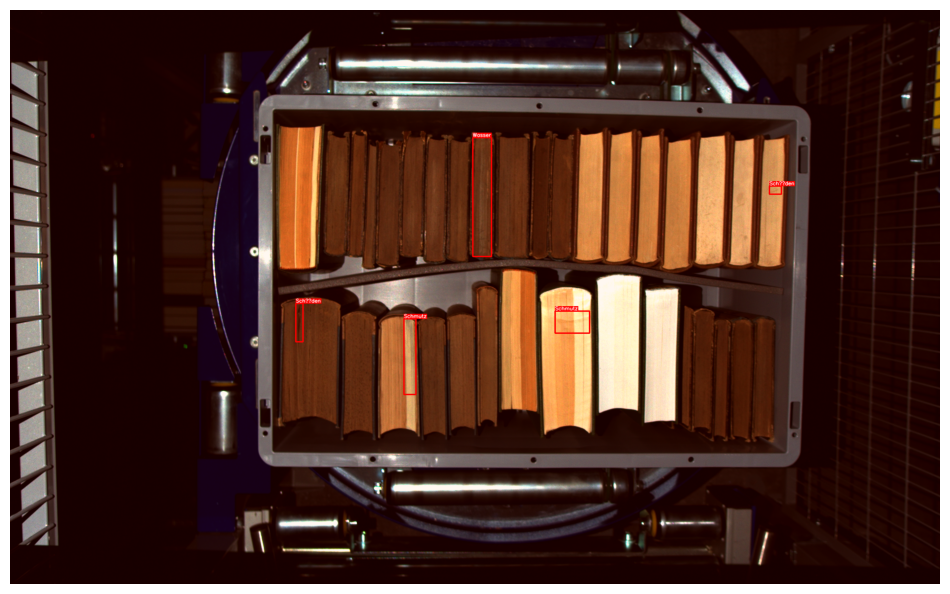

In [85]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_id)

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)
print(transformed)
print(transformed["image"].shape)
print(list(transformed["bboxes"][0]))
print(transformed["bboxes"][0][2] * transformed["bboxes"][0][3])

In [29]:
PATH_SAVE = "../../../old/BAA/Data/train_aug/"
img_name = "testimage.png"

## Save image

In [31]:
# save image
im = Image.fromarray(transformed["image"])
im.save(os.path.join(PATH_SAVE, img_name), "PNG")

# Production

## Functions for Production: Data (image) augmentation for a whole directory

In [2]:
def data_augmentation(path_to_images, path_to_save, path_to_annotations, new_name_addition = "A"):
	# dataload
	image_list = [os.path.join(path_to_images, filename) for filename in os.listdir(path_to_images) if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

	with open(path_to_annotations, "r") as f:
		coco_data = json.load(f)

	highest_img_id = coco_data["images"][-1]["id"]
	highest_ann_id = coco_data["annotations"][-1]["id"]

	# prep output
	def createSubsetStructure(originalData, description):
		subsetStructure = {
			"info": [{"year": int(datetime.date.today().year)},
					{"version": "1.0"},
					{"description": description},
					{"contributer": "Michael Infanger"},
					{"url": ""},
					{"date_created": str(datetime.datetime.now())}],
			"categories": originalData["categories"],
			"images": [],
			"annotations": []
		}
		return subsetStructure

	def writeJson(jsonObject, filename):
		if filename.split(".")[-1] != "json":
			filename = f"{filename}.json"
		with open(filename, "w") as g:
			g.write(jsonObject)

	new_coco_data = createSubsetStructure(coco_data, "Augmented_data_" + new_name_addition)

	# Augmentationpipeline
	transform = A.Compose([
			A.HorizontalFlip(p=0.6),
			A.ShiftScaleRotate(p=0.6),
			A.RandomBrightnessContrast(p=0.4),
			A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
		],
		bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
	)

	# category_id_to_name = {0:"Bildartefakte", 1:"Manuell Überprüfter Container", 2:"Schimmel", 3:"Schmutz", 4:"Schäden", 5:"Schädlinge", 6:"Sonstiges", 7:"Starke Überbeleuchtung oder Unterbeleuchtung", 8:"Unerwartetes Layout", 9:"Wasser"}

	for image_path in image_list:
		image_name = image_path.split("/")[-1]
		image = cv2.imread(image_path)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


		# dataprep
		img_id = -1
		for n in range(len(coco_data["images"])):
			if coco_data["images"][n]["file_name"] == image_name:
				img_id = coco_data["images"][n]["id"]

		annotations = []
		bboxes = []
		category_id = []
		for n in range(len(coco_data["annotations"])):
			if coco_data["annotations"][n]["image_id"] == img_id:
				annotations.append(coco_data["annotations"][n])
				bboxes.append(coco_data["annotations"][n]["bbox"])
				category_id.append(coco_data["annotations"][n]["category_id"])

		# run data augmentation
		transformed = transform(image=image, bboxes=bboxes, category_ids=category_id)
		alt_img_name = new_name_addition + image_name


		# prepare data to save in coco format
		highest_img_id += 1
		image_info = {
			"width": transformed["image"].shape[1],
            "height": transformed["image"].shape[0],
            "id": highest_img_id,
            "file_name": alt_img_name
			}

		new_coco_data["images"].append(image_info)

		for i in zip(transformed["bboxes"], transformed["category_ids"]):
			highest_ann_id += 1
			area_new = i[0][2] * i[0][3]
			annotation = {
				"id": highest_ann_id,
				"image_id": highest_img_id,
				"category_id": i[1],
				"segmentation": [],
				"bbox": list(i[0]),
				"ignore": 0,
				"iscrowd": 0,
				"area": area_new
        	}
			new_coco_data["annotations"].append(annotation)

		

		im = Image.fromarray(transformed["image"])
		im.save(os.path.join(path_to_save, alt_img_name), "PNG")

	json_file = json.dumps(new_coco_data, indent=4)
	writeJson(json_file, path_to_save +"Augmented_" + new_name_addition + "_" + path_to_annotations.split("/")[-1])

## Run Data (image) augmentation

imports are needed

writes files directly to the new folder

In [ ]:
import random
import json
import cv2
from matplotlib import pyplot as plt
import datetime

import albumentations as A

# Uncomment to run the function above
# data_augmentation("../../../old/BAA/Data/val_max/", "../../../old/BAA/Data/val_aug/", "../../../old/BAA/Data/val_max/coco_val_max.json")